# Laboratorio #1 – Detección de Pishing

In [17]:
import pandas as pd
import re
import math
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, roc_curve, auc

## Parte 1 – Ingeniería de características

In [2]:
df = pd.read_csv("dataset_pishing.csv")

In [3]:
# Mostrar un ejemplo de cinco observaciones
print("Ejemplo de cinco observaciones:")
print(df.head())


Ejemplo de cinco observaciones:
                                                 url      status
0              http://www.crestonwood.com/router.php  legitimate
1  http://shadetreetechnology.com/V4/validation/a...    phishing
2  https://support-appleld.com.secureupdate.duila...    phishing
3                                 http://rgipt.ac.in  legitimate
4  http://www.iracing.com/tracks/gateway-motorspo...  legitimate


In [4]:
status_counts = df["status"].value_counts()
print("\nCantidad de observaciones por categoría:")
print(status_counts)


Cantidad de observaciones por categoría:
status
legitimate    5715
phishing      5715
Name: count, dtype: int64


In [5]:
balance_ratio = status_counts["legitimate"] / status_counts["phishing"] if "phishing" in status_counts else None
print("\nBalance del dataset:")
print(f"Proporción entre clases (legitimate/phishing): {balance_ratio:.2f}")


Balance del dataset:
Proporción entre clases (legitimate/phishing): 1.00


##### ¿Qué ventajas tiene el análisis de una URL contra el análisis de otros datos, cómo el tiempo de vida del dominio, o las características de la página Web?

Alguna de las ventajas pueden ser:

- Detección en tiempo real: Las páginas de phishing suelen tener una vida útil corta, a veces solo unas pocas horas. El análisis de URL permite detectar amenazas sin necesidad de cargar la página, lo que mejora la velocidad de detección​ y es por ello que se llega a detectar de manera instantanea

- Independencia de idioma: No depende del idioma del contenido de la página, lo que lo hace aplicable a sitios web globales​

- No depende de servicios de terceros: Algunos enfoques requieren consultas a servicios como WHOIS o listas negras, lo que puede ralentizar la detección y hacerla dependiente de servicios externos​

- Detección de ataques de "día cero": Puede identificar nuevas amenazas de phishing sin depender de listas de dominios maliciosos previamente identificados​


##### ¿Qué características de una URL son más prometedoras para la detección de phishing?

Algunas de las caracteristicas son:

- Observar la longitud de la URL y del dominio: Los sitios de phishing suelen usar URLs largas para ocultar la identidad real del dominio​

- Uso de direcciones IP en la URL: Los atacantes suelen usar direcciones IP en lugar de nombres de dominio​

- Número de subdominios: Los sitios de phishing tienden a incluir múltiples subdominios para parecer legítimos​

- Presencia de caracteres especiales: Caracteres como "-", "@" y "?" pueden indicar intentos de uan direccion falsa

- Uso de Punycode: Los sitios maliciosos pueden emplear caracteres Unicode en los nombres de dominio para parecer legítimos​

- HTTPS vs HTTP: Aunque algunos sitios de phishing usan HTTPS, muchos siguen operando con HTTP​

- Cantidad de números en la URL: Un número excesivo de dígitos en la URL puede indicar phishing​

- Uso de servicios de acortamiento de URL: Los atacantes usan acortadores para ocultar la URL real​

- Número de guiones en el dominio: Sitios de phishing suelen incluir guiones para imitar dominios legítimos​

- Posición del TLD: Si el TLD aparece en la parte de la ruta de la URL en lugar del dominio, puede ser indicativo de phishing​

- Presencia de palabras clave sospechosas: Palabras como "login", "secure", "bank", "update" pueden ser indicativos de phishing​

- Número de parámetros en la URL: Un alto número de parámetros puede indicar intentos de manipulación​

- Frecuencia de caracteres no alfanuméricos: La entropía de caracteres especiales puede ser usada para detectar URLs de phishing​

- Presencia de direcciones de correo en la URL: Los sitios de phishing pueden incluir direcciones de correo falsas en la URL​

- Entropía de Shannon y relativa: Mide la aleatoriedad de la cadena de la URL, útil para detectar URLs generadas automáticamente​



In [6]:
def shannon_entropy(string):
    prob = [float(string.count(c)) / len(string) for c in dict.fromkeys(list(string))]
    entropy = -sum([p * math.log2(p) for p in prob])
    return entropy

In [7]:

def relative_entropy(string):
    return shannon_entropy(string) / math.log2(len(string)) if len(string) > 1 else 0


In [8]:

def extract_features(url):
    parsed = urlparse(url)
    domain = parsed.netloc
    path = parsed.path
    
    features = {
        "url_length": len(url),
        "domain_length": len(domain),
        "num_subdomains": domain.count('.'),
        "contains_ip": bool(re.match(r'^\d{1,3}(\.\d{1,3}){3}$', domain)),
        "num_special_chars": sum([url.count(c) for c in "-@?&|=_~%/"]),
        "https_token": 1 if url.startswith("https") else 0,
        "digit_ratio": sum(c.isdigit() for c in url) / len(url),
        "shortened_url": 1 if any(service in url for service in ["bit.ly", "goo.gl", "tinyurl"]) else 0,
        "num_hyphens": domain.count("-"),
        "tld_position": 1 if ".com/" in path or ".net/" in path else 0,
        "num_suspicious_words": sum(1 for word in ["login", "secure", "bank", "update"] if word in url),
        "num_parameters": url.count("="),
        "email_in_url": 1 if "@" in url else 0,
        "shannon_entropy": shannon_entropy(url),
        "relative_entropy": relative_entropy(url)
    }
    return features

                                                 url      status  url_length  \
0              http://www.crestonwood.com/router.php  legitimate          37   
1  http://shadetreetechnology.com/V4/validation/a...    phishing          77   
2  https://support-appleld.com.secureupdate.duila...    phishing         126   
3                                 http://rgipt.ac.in  legitimate          18   
4  http://www.iracing.com/tracks/gateway-motorspo...  legitimate          55   

   domain_length  num_subdomains  contains_ip  num_special_chars  https_token  \
0             19               2        False                  3            0   
1             23               1        False                  5            0   
2             50               4        False                 14            1   
3             11               2        False                  2            0   
4             15               2        False                  7            0   

   digit_ratio  shortened_url  n

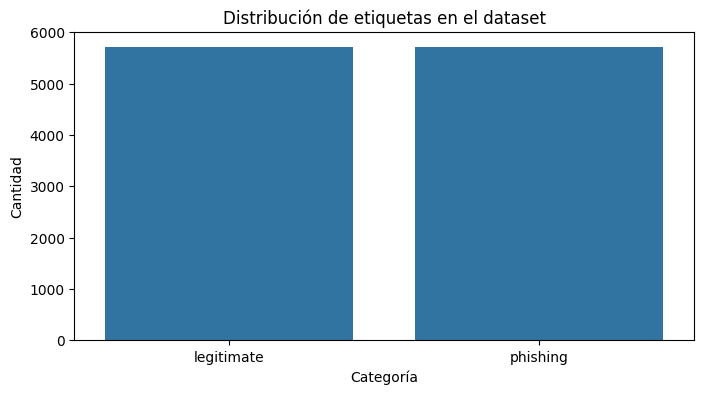

In [9]:

df_features = df["url"].apply(lambda x: extract_features(x)).apply(pd.Series)
df = pd.concat([df, df_features], axis=1)


df.to_csv("dataset_enriquecido.csv", index=False)


print(df.head())


plt.figure(figsize=(8, 4))
sns.countplot(x=df["status"])
plt.title("Distribución de etiquetas en el dataset")
plt.xlabel("Categoría")
plt.ylabel("Cantidad")
plt.show()

In [10]:

df_features = df["url"].apply(lambda x: extract_features(x)).apply(pd.Series)
df_binaria = pd.concat([df, df_features], axis=1)

                                                 url  status  url_length  \
0              http://www.crestonwood.com/router.php       0          37   
1  http://shadetreetechnology.com/V4/validation/a...       1          77   
2  https://support-appleld.com.secureupdate.duila...       1         126   
3                                 http://rgipt.ac.in       0          18   
4  http://www.iracing.com/tracks/gateway-motorspo...       0          55   

   num_subdomains  contains_ip  num_special_chars  https_token  digit_ratio  \
0               2        False                  3            0     0.000000   
1               1        False                  5            0     0.220779   
2               4        False                 14            1     0.150794   
3               2        False                  2            0     0.000000   
4               2        False                  7            0     0.000000   

   shortened_url  num_hyphens  ...  https_token  digit_ratio  shorte

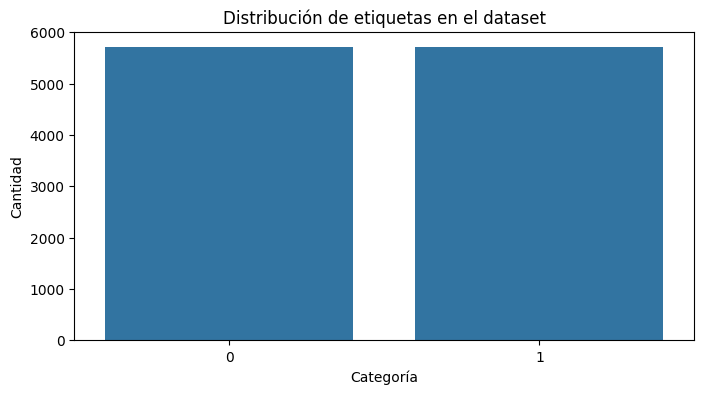

In [11]:

df_binaria['status'] = df_binaria['status'].map({'legitimate': 0, 'phishing': 1})


df_binaria.drop(columns=['domain_length'], inplace=True, errors='ignore')


df_binaria.to_csv("dataset_enriquecido_binario.csv", index=False)


print(df_binaria.head())


plt.figure(figsize=(8, 4))
sns.countplot(x=df_binaria["status"])
plt.title("Distribución de etiquetas en el dataset")
plt.xlabel("Categoría")
plt.ylabel("Cantidad")
plt.show()


## Parte 2 – Implementación

In [14]:
df_binaria_implemetation = df_binaria

X = df_binaria_implemetation.drop(columns=["url", "status"])
y = df_binaria_implemetation["status"]

In [15]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.45, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42, stratify=y_temp)

In [16]:
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

train_df.to_csv("train.csv", index=False)
val_df.to_csv("val.csv", index=False)
test_df.to_csv("test.csv", index=False)

### Árbol de Decisión

In [19]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

### SVM

In [20]:
svm_model = SVC(probability=True, random_state=42)
svm_model.fit(X_train, y_train)

SVC(probability=True, random_state=42)

### Predicciones

In [21]:
y_val_pred_dt = dt_model.predict(X_val)
y_test_pred_dt = dt_model.predict(X_test)

y_val_pred_svm = svm_model.predict(X_val)
y_test_pred_svm = svm_model.predict(X_test)

In [22]:
print("Modelo: Árbol de Decisión (Validación):")
print(classification_report(y_val, y_val_pred_dt))

print("Modelo: Árbol de Decisión (Prueba):")
print(classification_report(y_test, y_test_pred_dt))

Modelo: Árbol de Decisión (Validación):
              precision    recall  f1-score   support

           0       0.75      0.75      0.75       857
           1       0.75      0.74      0.75       857

    accuracy                           0.75      1714
   macro avg       0.75      0.75      0.75      1714
weighted avg       0.75      0.75      0.75      1714

Modelo: Árbol de Decisión (Prueba):
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      1715
           1       0.75      0.75      0.75      1715

    accuracy                           0.75      3430
   macro avg       0.75      0.75      0.75      3430
weighted avg       0.75      0.75      0.75      3430



In [23]:
print("Modelo: SVM (Validación):")
print(classification_report(y_val, y_val_pred_svm))

print("Modelo: SVM (Prueba):")
print(classification_report(y_test, y_test_pred_svm))

Modelo: SVM (Validación):
              precision    recall  f1-score   support

           0       0.60      0.89      0.72       857
           1       0.79      0.41      0.54       857

    accuracy                           0.65      1714
   macro avg       0.70      0.65      0.63      1714
weighted avg       0.70      0.65      0.63      1714

Modelo: SVM (Prueba):
              precision    recall  f1-score   support

           0       0.59      0.88      0.71      1715
           1       0.77      0.40      0.52      1715

    accuracy                           0.64      3430
   macro avg       0.68      0.64      0.62      3430
weighted avg       0.68      0.64      0.62      3430



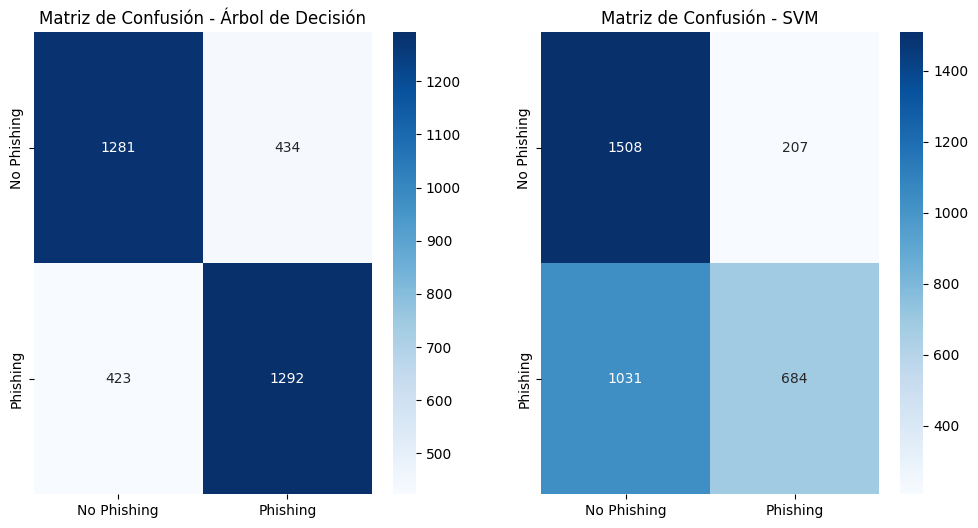

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Árbol de Decisión
cm_dt = confusion_matrix(y_test, y_test_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', xticklabels=["No Phishing", "Phishing"], yticklabels=["No Phishing", "Phishing"], ax=axes[0])
axes[0].set_title("Matriz de Confusión - Árbol de Decisión")

# SVM
cm_svm = confusion_matrix(y_test, y_test_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Phishing", "Phishing"], yticklabels=["No Phishing", "Phishing"], ax=axes[1])
axes[1].set_title("Matriz de Confusión - SVM")

plt.show()


In [26]:
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_model.predict_proba(X_test)[:, 1])
roc_auc_dt = auc(fpr_dt, tpr_dt)

fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_model.predict_proba(X_test)[:, 1])
roc_auc_svm = auc(fpr_svm, tpr_svm)

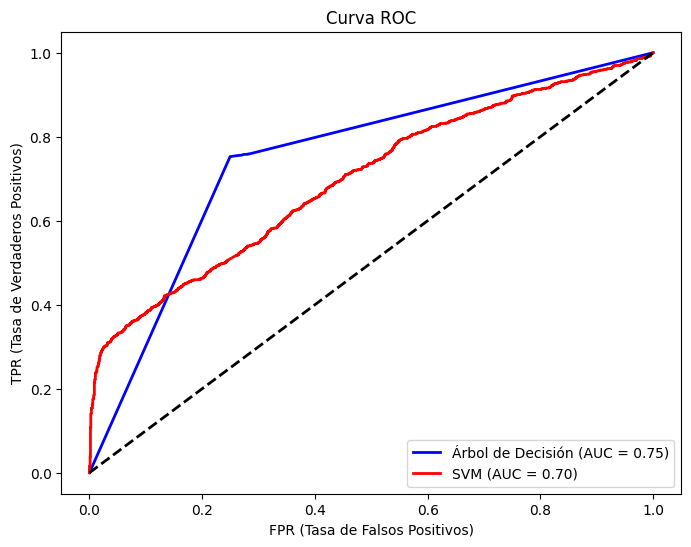

In [27]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, color='blue', lw=2, label=f'Árbol de Decisión (AUC = {roc_auc_dt:.2f})')
plt.plot(fpr_svm, tpr_svm, color='red', lw=2, label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('FPR (Tasa de Falsos Positivos)')
plt.ylabel('TPR (Tasa de Verdaderos Positivos)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [28]:
print(f"AUC - Árbol de Decisión: {roc_auc_dt:.2f}")
print(f"AUC - SVM: {roc_auc_svm:.2f}")

AUC - Árbol de Decisión: 0.75
AUC - SVM: 0.70


##### ¿Cuál es el impacto de clasificar un sitio legítimo como phishing?

Cuando un sitio legítimo es clasificado erróneamente como phishing, los usuarios pueden experimentar restricciones innecesarias y no poder acceder a sitios seguros. Esto podría generar problemas operativos, como bloquear páginas web esenciales para el trabajo, interrumpiendo la productividad. Además, los administradores de seguridad podrían gastar recursos en analizar y desbloquear sitios que no representan una amenaza.

#### ¿Cuál es el impacto de clasificar un sitio de phishing como legítimo?

Cuando un sitio de phishing es clasificado erróneamente como legítimo, los usuarios pueden ser víctimas de ataques, exponiendo credenciales, información financiera o datos sensibles. Este error es más grave que un falso positivo, ya que permite que los atacantes ejecuten fraudes y comprometan la seguridad de la empresa o los usuarios individuales.

#### ¿Qué métrica elegiría para comparar modelos similares de clasificación de phishing?

Dado que el mayor riesgo es clasificar erróneamente un sitio de phishing como legítimo, la métrica más importante es el Recall para la clase "phishing".
- Recall mide qué porcentaje de los sitios de phishing fueron detectados correctamente.
- Un modelo con alto Recall minimiza los falsos negativos, reduciendo el riesgo de que los usuarios accedan a sitios maliciosos.
- El F1-score también es importante porque equilibra precisión y recall.

#### ¿Qué modelo funcionó mejor para la clasificación de phishing? ¿Por qué?

En este problema, donde los falsos negativos son críticos, el Árbol de Decisión es la mejor opción porque:

- Tiene una precisión balanceada en ambas clases.
- Su Recall para phishing es significativamente mejor que el de SVM (0.75 vs. 0.40), lo que reduce los falsos negativos.
- El AUC del Árbol de Decisión es 0.75, mientras que el de SVM es 0.70, lo que indica que el Árbol de Decisión tiene mejor capacidad de discriminación entre clases.


#### Una empresa desea utilizar su mejor modelo, debido a que sus empleados sufren constantes ataques de phishing mediante e-mail. La empresa estima que, de un total de 50,000 emails, un 15% son phishing. ¿Qué cantidad de alarmas generaría su modelo? ¿Cuántas positivas y cuantas negativas? ¿Funciona el modelo para el BR propuesto? En caso negativo, ¿qué propone para reducir la cantidad de falsas alarmas?